In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

In [10]:
# Set Paths
train_dir = 'Training' 
test_dir = 'Testing'    
img_size = 224
batch_size = 32

# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data Loaders
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

Found 4800 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [11]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = True  # Full fine-tuning

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model_vgg19 = Model(inputs=base_model.input, outputs=output)
model_vgg19.compile(optimizer=Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history_vgg19 = model_vgg19.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop, lr_reduce]
)

C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3086s 21s/step - accuracy: 0.5699 - loss: 0.9545 - val_accuracy: 0.8267 - val_loss: 0.5364 - learning_rate: 5.0000e-05
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3105s 21s/step - accuracy: 0.8678 - loss: 0.3647 - val_accuracy: 0.8550 - val_loss: 0.3923 - learning_rate: 5.0000e-05
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2931s 20s/step - accuracy: 0.9195 - loss: 0.2352 - val_accuracy: 0.8833 - val_loss: 0.3269 - learning_rate: 5.0000e-05
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2934s 20s/step - accuracy: 0.9446 - loss: 0.1766 - val_accuracy: 0.9392 - val_loss: 0.1643 - learning_rate: 5.0000e-05
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2934s 20s/step - accuracy: 0.9457 - loss: 0.1696 - val_accuracy: 0.9692 - val_loss: 0.1121 - learning_rate: 5.0000e-05
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2993s 20s/step - accuracy: 0.9557 - loss: 0.1245 - val_accuracy: 0.9625 - val_loss: 0.0986 - learning_rate: 5.0000e-05
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2984s 

In [13]:
model_vgg19.save("vgg19_brain_tumor_model.h5")
print("✅ VGG19 model saved as 'vgg19_brain_tumor_model.h5'")

✅ VGG19 model saved as 'vgg19_brain_tumor_model.h5'


In [14]:
loss, acc = model_vgg19.evaluate(test_generator)
y_pred = np.argmax(model_vgg19.predict(test_generator), axis=1)
y_true = test_generator.classes

print(f"VGG19 Accuracy: {acc:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 195s 5s/step - accuracy: 0.9862 - loss: 0.0595
38/38 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step
VGG19 Accuracy: 0.9883


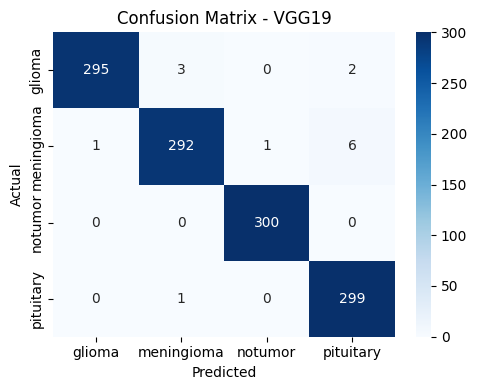

<Figure size 640x480 with 0 Axes>

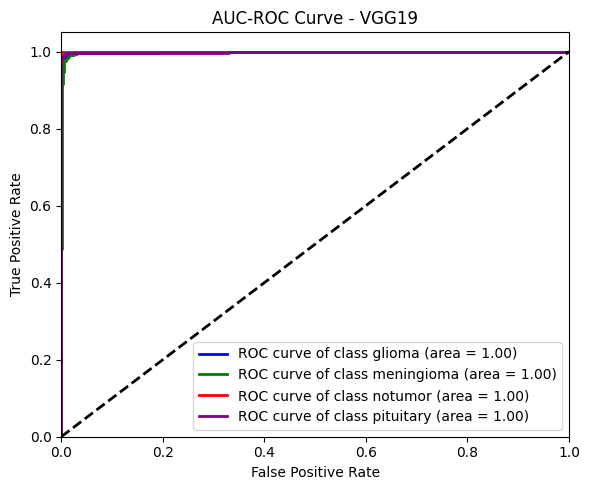

<Figure size 640x480 with 0 Axes>

In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Set model name
model_name = "VGG19"

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()  # <-- Display in notebook
plt.savefig(f"conf_matrix_{model_name}.png")

# Plot AUC-ROC Curve
# Binarize true labels
y_test_bin = label_binarize(y_true, classes=[i for i in range(num_classes)])
fpr = dict()
tpr = dict()
roc_auc_dict = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])

# Plotting
colors = cycle(['blue', 'green', 'red', 'purple'])
plt.figure(figsize=(6, 5))
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc_dict[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'AUC-ROC Curve - {model_name}')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show() 
plt.savefig(f"roc_auc_{model_name}.png")

In [16]:
# Plot & Save Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - VGG19")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("conf_matrix_VGG19.png")
plt.close()

# Save results to CSV
model_results = pd.DataFrame([{
    "Model": "VGG19",
    "Accuracy": acc,
    "Precision": cr['macro avg']['precision'],
    "Recall": cr['macro avg']['recall'],
    "Specificity": specificity,
    "F1-Score": cr['macro avg']['f1-score'],
    "ROC-AUC": roc_auc,
    "TP": tp,
    "TN": tn,
    "FP": fp,
    "FN": fn
}])

results_file = "all_model_results.csv"
if os.path.exists(results_file):
    model_results.to_csv(results_file, mode='a', index=False, header=False)
else:
    model_results.to_csv(results_file, index=False)

print("📁 VGG19 results saved to CSV and confusion matrix image.")

📁 VGG19 results saved to CSV and confusion matrix image.
